In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import quantstats as qs
import warnings

warnings.filterwarnings("ignore")
qs.extend_pandas()

In [14]:
def load_daily_data(ticker):
    df = pdr.DataReader(ticker, 'yahoo', start = '1996-01-01')[['Open','High','Low','Close','Volume','Adj Close']].reset_index()
    df['Ratio'] = df['Adj Close'] / df['Close']
    df['Open'] = df['Open'] * df['Ratio']
    df['High'] = df['High'] * df['Ratio']
    df['Low'] = df['Low'] * df['Ratio']
    df['Close'] = df['Close'] * df['Ratio']
    df = df.drop(['Ratio', 'Adj Close'], axis = 1)
    df.columns = ['date','open','high','low','close','volume']
    df = df.set_index(['date'])
    df = df.dropna()
    
    return df

In [15]:
def strategy7(df):
    data = df
    
    LenTrd = 20
    Days1 = 5
    Days2 = 4
    
    data['UnboundedDV2'] = (data.close / ((data.high.rolling(LenTrd).max() 
                                          + data.low.rolling(LenTrd).min())/2)).rolling(Days1).mean() - 1
    data['DV2B'] = data.UnboundedDV2.rolling(252).rank(pct = True)
    data['MarkInd01'] = np.where(data.DV2B  < data.DV2B.shift(1), 1, 0)
    data['MarkInd01'] = data.MarkInd01.rolling(Days2).sum() == Days2
    data['Filter01'] = np.abs((data.open - data.close).shift(1)) > (.75 * (data.high - data.low).shift(1))
    
    data['BUY'] = data.MarkInd01 & data.Filter01
    data['SELL'] = data.close > data.high.rolling(5).mean()
    
    return data

In [16]:
def backtest(data, report = False, snapshot = False, dataframe = False):
    inPosition = False
    buydates, selldates = [], []
    for i in range(len(data)-2):
        if not inPosition:
            if data.iloc[i].BUY:
                buydates.append(data.iloc[i + 2].name)
                inPosition = True
                
        if inPosition:
            if data.iloc[i].SELL:
                selldates.append(data.iloc[i + 2].name)
                inPosition = False
    
    returns = []
    
    for j in range(min(len(buydates), len(selldates))):
        frame = data[(data.index >= buydates[j]) & (data.index <= selldates[j])]
        returns.append(frame.open.pct_change().fillna(0))
    
    dfReturns = pd.concat(returns)
    indexdata = pd.DataFrame(index = data.index)
    dfReturns = pd.concat([dfReturns, indexdata], axis = 1, ignore_index = False).fillna(0)
    
    if report == True:
        return qs.reports.full(dfReturns.open, 'SPY')
    if snapshot == True:
        return qs.plots.snapshot(dfReturns.open)
    if dataframe == True:
        return dfReturns
    

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1999-03-10  1999-03-10
End Period                 2022-06-30  2022-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             11.0%       100.0%

Cumulative Return          353.03%     346.87%
CAGR﹪                     6.69%       6.63%

Sharpe                     0.72        0.43
Prob. Sharpe Ratio         99.94%      97.98%
Smart Sharpe               0.7         0.41
Sortino                    1.15        0.6
Smart Sortino              1.12        0.58
Sortino/√2                 0.81        0.42
Smart Sortino/√2           0.79        0.41
Omega                      1.48        1.48

Max Drawdown               -24.55%     -55.19%
Longest DD Days            906         2404
Volatility (ann.)          9.7%        19.7%
R^2                        0.01        0.01
Information Ratio          -0.0        -0.0
Calmar                     0.27        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-01-14,2009-03-09,2010-07-08,906,-24.547231,-21.828692
2,2001-12-19,2002-05-07,2003-07-07,565,-13.974223,-10.827823
3,2011-03-23,2011-10-04,2012-06-29,464,-10.926905,-6.457391
4,2000-09-15,2001-04-09,2001-04-11,208,-8.279441,-5.512153
5,2020-03-04,2020-03-06,2020-11-04,245,-5.729824,-4.396895


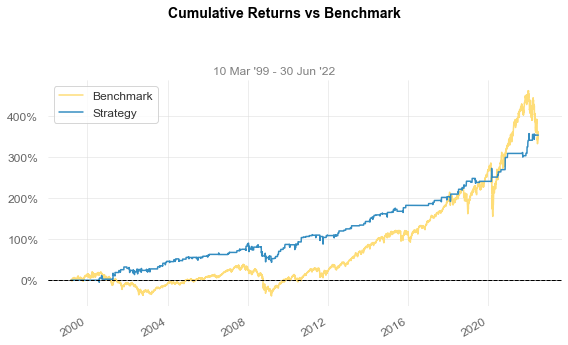

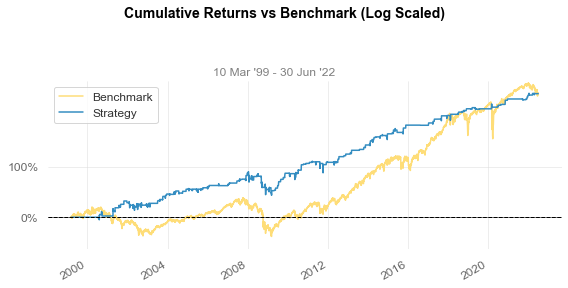

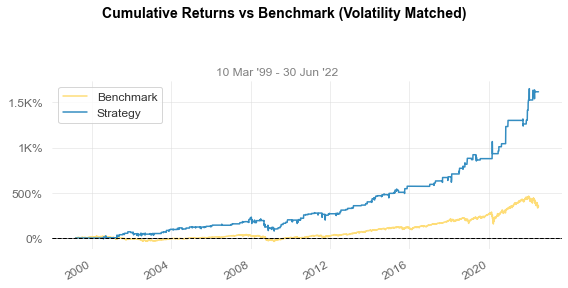

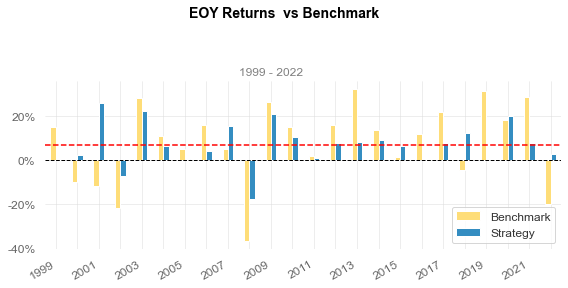

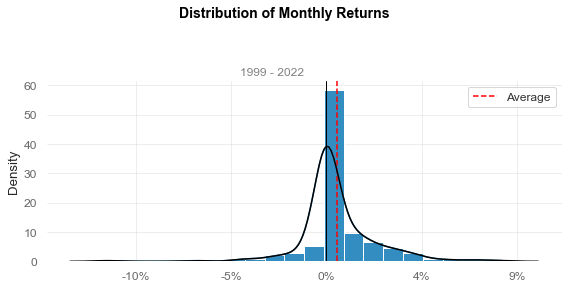

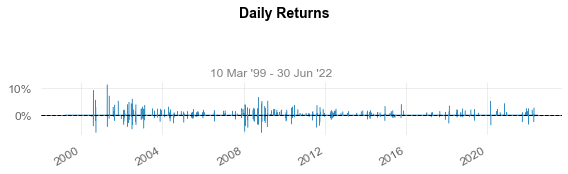

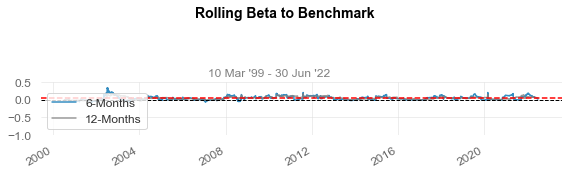

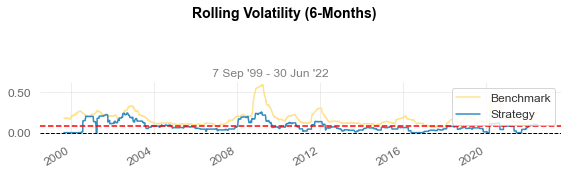

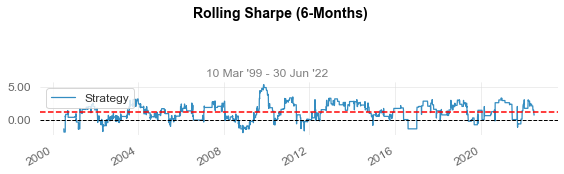

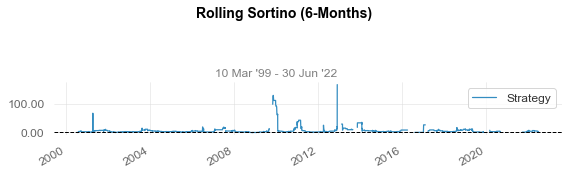

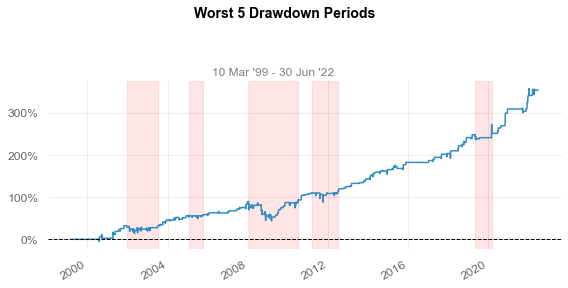

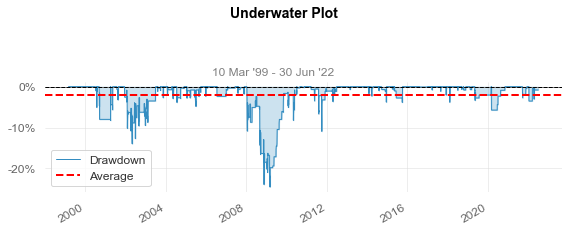

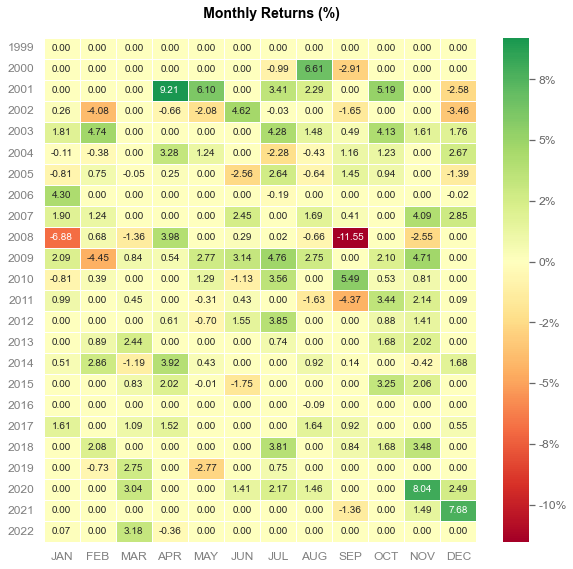

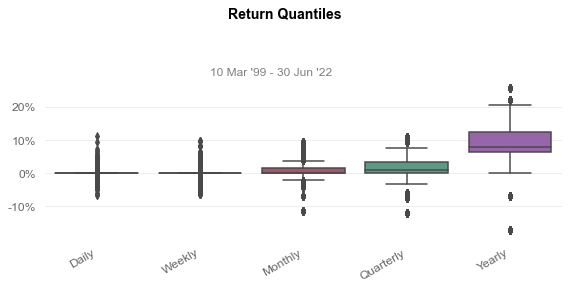

In [17]:
QQQ = load_daily_data('QQQ')
strat7 = strategy7(QQQ)
backtest(data = strat7, report = True, snapshot = False, dataframe = False)